In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from food.paths import *
from stego.segment import get_food_segment
from segmentor.segment import *

dev
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/home/dima/FoodSeg103-Benchmark-v1/checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [3]:
from mytools.visual import *

In [4]:
bad_cats = ['Vegetables on a sandwich']


foods = pd.read_sql("""select f.*
                        from food.foods_prompted f""",engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

foods = foods[~foods['category'].isin(bad_cats)]

food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/tools.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [5]:
url = 'https://image.shutterstock.com/z/stock-photo-rice-porridgeon-milk-with-butter-2137740367.jpg'
img = get_image_from_url(url)
img = crop_image_to_square(img)
total_size = img.size[0]*img.size[1]

photo_id = url.split('/')[-1]

In [6]:
i = np.asarray(img, dtype="uint8")
i = np.flip(i,2)

segmentor_mask = inference_segmentor(segment_model, i)[0]

classes = np.unique(segmentor_mask)[1:]
classes_ =[]
urls = []
for c in classes:
    area = segmentor_mask[segmentor_mask==c].shape[0]
    if area> 20*20:
        class_mask = np.where(segmentor_mask==c,1,0)
        class_mask = expand_boundaries(class_mask,times=5,factor=5)
        img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
        img_arr = crop_zeros(img_arr)
        img_arr[img_arr==[0,0,0]]=255 #replace black with while
        fname = f'{photo_id}_{c}.jpg'

        Image.fromarray(img_arr).save(fragment_reference_images_path/fname)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{fname}')
        classes_.append(c+1)

classes = classes_

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


### inference with stego

In [7]:
stego_img,stego_mask = get_food_segment(img)
stego_img.save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_stego.jpg')
    

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [8]:
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,foods,food_clips,head = 1)[1])
clip_df=clip_df.reset_index(drop=True)
clip_df['classes'] = classes+[1]
# clip_df = clip_df[:-1][clip_df[:-1]['score']>0.24].append(clip_df.iloc[-1])

/tmp/ipykernel_3118188/1127422320.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,foods,food_clips,head = 1)[1])
/tmp/ipykernel_3118188/1127422320.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,foods,food_clips,head = 1)[1])
/tmp/ipykernel_3118188/1127422320.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,foods,food_clips,head = 1)[1])


In [9]:
clip_df

,id,description,category,energy,protein,carb,fat,text,clip,score,classes
0,1103833,"Margarine-oil blend, tub, light",Margarine,346.0,0.33,1.22,37.91,the food is margarine . it has a little bit of...,"[0.009067799, -0.00876648, -0.008507334, 0.015...",0.256926,9
1,1102548,"Rice soup, NFS",Soups,34.0,0.92,5.80,0.78,the food is soups . it has a little bit of n...,"[0.033272248, -0.013115205, 0.010876191, -0.00...",0.277195,16
2,1102517,"Upma, Indian breakfast dish",Grits and other cooked cereals,86.0,1.98,13.81,2.64,the food is grits and other cooked cereals . i...,"[-0.0018043444, -0.031428985, -0.018850923, 0....",0.271844,1


In [10]:
mask = stego_mask+segmentor_mask

In [11]:
calories_dict = clip_df[['classes','energy']].set_index("classes")['energy'].to_dict()
for c in np.unique(mask):
    if c not in calories_dict.keys():
        mask[mask==c]=0
for k,v in calories_dict.items():
    mask[mask == k] = v

In [12]:
mask[mask!=0].mean()

tensor(90.6102, dtype=torch.float64)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


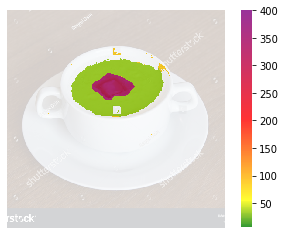

In [13]:
i = visualize_array(mask.numpy(),img).resize((500,500))